# Aggregate the snow reanalyses HMASR to coarser resolutions

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:44595 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 24.00 GB


In [30]:
client.close()

- FORCING_POST -> PPT_Post
- SD_POST -> SD_Post
- SWE_SCA_POST -> SWE_Post, SCA_Post

## Aggregate data in parallel
There are different option with `dask`. I didn't succeed to make it work with `xr.open_mfdataset` as there are too many files and there is a memory crash. So I finally used the `delayed` option from dask, in order to parallelize a loop.

Here are the different ressources:
- http://xarray.pydata.org/en/stable/user-guide/dask.html
- https://ncar.github.io/xdev/posts/writing-multiple-netcdf-files-in-parallel-with-xarray-and-dask/ (I use this on for writting in parallel)
- https://tutorial.dask.org/01_dask.delayed.html (I used this example for delayed)

The delayed from dask is a bit tricky and we can't use all functions.

The goal here is just to coarsen grids. Then I will put all the files together in a single file for efficiency.

In [4]:
from os import listdir

WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
    path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'+WY+'/'
    
    for ds_name in ds_name_list:
        print(ds_name)
        list_files = [f for f in listdir(path) if ds_name in f]
        
        ds_100km = []
        for file in list_files:
            ds = delayed(xr.open_dataset)(path+file)
            
            if ds_name in ['FORCING_POST']:
                ds_100km.append(ds.coarsen(Latitude=225, Longitude=225).mean())
            else:
                # Select only the mean (Stats=0)
                ds_100km.append(ds.isel(Stats=0).coarsen(Latitude=225, Longitude=225).mean())
                
        ds_100km = compute(ds_100km)
        xr.save_mfdataset(ds_100km[0], [path_out+file for file in list_files])

WY1999_00
FORCING_POST
SD_POST
SWE_SCA_POST
WY2000_01
FORCING_POST
SD_POST
SWE_SCA_POST
WY2001_02
FORCING_POST
SD_POST
SWE_SCA_POST
WY2002_03
FORCING_POST
SD_POST
SWE_SCA_POST
WY2003_04
FORCING_POST
SD_POST
SWE_SCA_POST
WY2004_05
FORCING_POST
SD_POST
SWE_SCA_POST
WY2005_06
FORCING_POST
SD_POST
SWE_SCA_POST
WY2006_07
FORCING_POST
SD_POST
SWE_SCA_POST
WY2007_08
FORCING_POST
SD_POST
SWE_SCA_POST
WY2008_09
FORCING_POST
SD_POST
SWE_SCA_POST
WY2009_10
FORCING_POST
SD_POST
SWE_SCA_POST
WY2010_11
FORCING_POST
SD_POST
SWE_SCA_POST
WY2011_12
FORCING_POST
SD_POST
SWE_SCA_POST
WY2012_13
FORCING_POST
SD_POST
SWE_SCA_POST
WY2013_14
FORCING_POST
SD_POST
SWE_SCA_POST
WY2014_15
FORCING_POST
SD_POST
SWE_SCA_POST
WY2015_16
FORCING_POST
SD_POST
SWE_SCA_POST
WY2016_17
FORCING_POST
SD_POST
SWE_SCA_POST


### Old version for testing one by one

In [20]:
# WY = 'WY1999_00'
WY = 'WY2001_02'

In [21]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_D/'+WY+'/'
path_out = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'+WY+'/'

In [22]:
from os import listdir
# list_files = [f for f in listdir(path) if 'SWE_SCA_POST' in f]
list_files = [f for f in listdir(path) if 'SWE_SCA_POST' in f]
list_files[:10]

['HMA_SR_D_v01_N27_0E100_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E66_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E67_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E83_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E84_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E85_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E86_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E87_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E88_0_agg_16_WY2001_02_SWE_SCA_POST.nc',
 'HMA_SR_D_v01_N27_0E89_0_agg_16_WY2001_02_SWE_SCA_POST.nc']

In [ ]:
%%time
ds_100km = []
for file in list_files:
    ds = delayed(xr.open_dataset)(path+file)
    ds_100km.append(ds.isel(Stats=0).coarsen(Latitude=225, Longitude=225).mean())
#     ds_100km.append(ds.coarsen(Latitude=225, Longitude=225).mean())

ds_100km = compute(ds_100km)
xr.save_mfdataset(ds_100km[0], [path_out+file for file in list_files])

In [125]:
ds_test = ds_test.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds_test.Day.size, freq='D'))
swe = ds_test.SWE_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
scf = ds_test.SCA_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


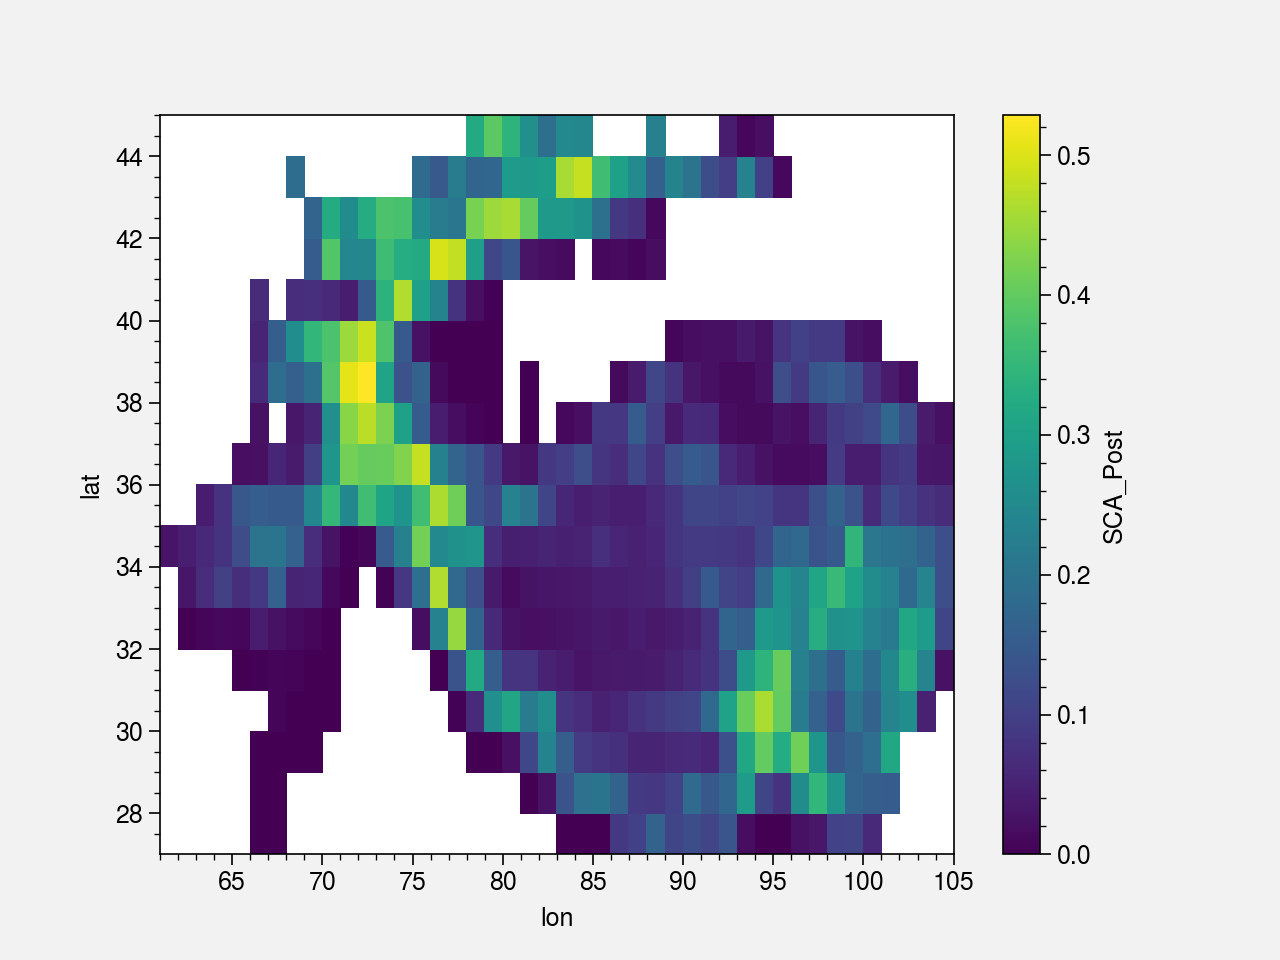

In [126]:
scf.mean('time').plot()

### Test to regrid on elevation file
In practise there is no need to regrid here for 1° resolution. Only problem for HMASR lat/lon are in float64 while GMTED in float34 so we just need to harmonize this. Otherwise we loose the sides by regriding...

In [94]:
scf.load()

<xarray.DataArray 'SCA_Post' (time: 366, lat: 18, lon: 44)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
Dimensions without coordinates: time

In [89]:
latlim = slice(27, 45)
lonlim = slice(60, 105)

In [90]:
ds = xr.open_dataset('../data/GMTED2010/GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [95]:
# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(scf, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
scf_regrid = regridder(scf)

Reuse existing file: bilinear_18x44_18x45.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [113]:
scf.lon

<xarray.DataArray 'lon' (lon: 44)>
array([ 61.499966,  62.499966,  63.499966,  64.500389,  65.500389,  66.500389,
        67.500389,  68.500389,  69.500389,  70.500389,  71.500389,  72.500389,
        73.500397,  74.500397,  75.500397,  76.500397,  77.500397,  78.500397,
        79.500381,  80.500381,  81.500381,  82.500381,  83.500381,  84.500381,
        85.500381,  86.500381,  87.500381,  88.500381,  89.500381,  90.500381,
        91.500381,  92.500381,  93.500381,  94.500381,  95.500381,  96.500381,
        97.500381,  98.500381,  99.500381, 100.500381, 101.500381, 102.500381,
       103.500381, 104.500381])
Coordinates:
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5

In [112]:
elevation.lon

<xarray.DataArray 'lon' (lon: 45)>
array([ 60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
        90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,  99.5,
       100.5, 101.5, 102.5, 103.5, 104.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 60.5 61.5 62.5 63.5 64.5 ... 101.5 102.5 103.5 104.5
Attributes:
    long_name:  longitude of grid cell centre
    units:      degrees_east
    bounds:     longitude_bounds
    axis:       X

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


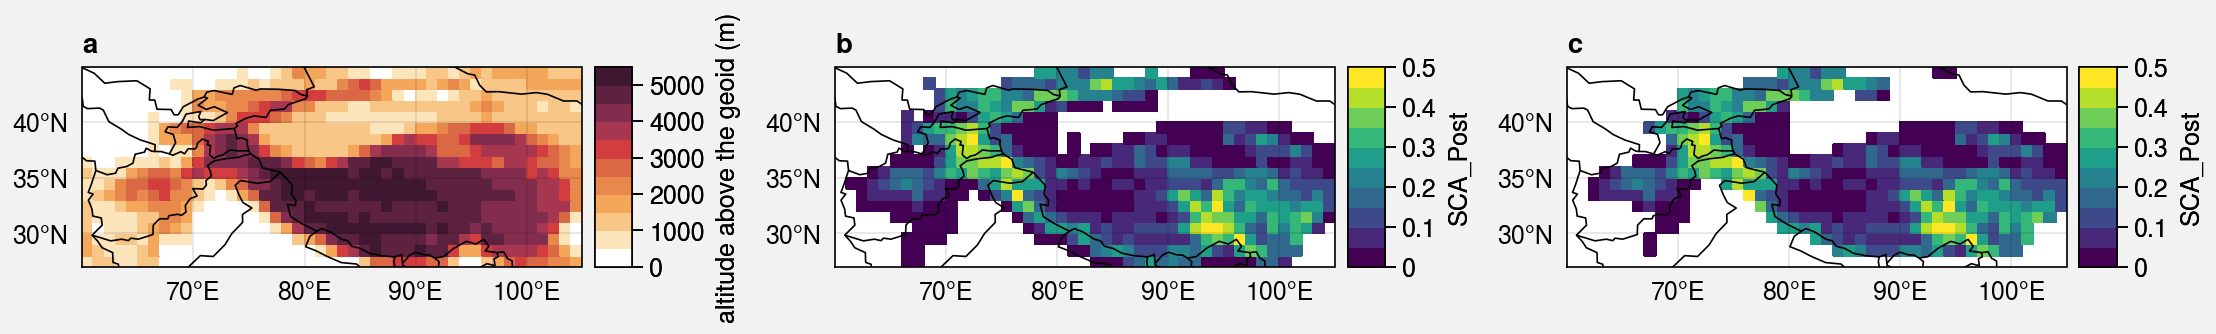

In [102]:
fig, axs = plot.subplots(nrows=1, ncols=3, proj='cyl')

axs[0].pcolormesh(elevation, colorbar='r')
axs[1].pcolormesh(scf.mean('time'), colorbar='r', cmap='viridis')
axs[2].pcolormesh(scf_regrid.mean('time'), colorbar='r', cmap='viridis')

axs.format(
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    borders=True, abc=True
)

## Combine files to a single file
Add also dates and rename/reorganize dimensions

In [36]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'
WY_list = ['WY'+str(year)+'_'+str(i).zfill(2) for i, year in enumerate(range(1999, 2017))]
ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']

for WY in WY_list:
    print(WY)
    for ds_name in ds_name_list:
        print(ds_name)
        ds = xr.open_mfdataset(path+WY+'/*'+ds_name+'*', parallel=True)
        ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
        ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
        ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_'+ds_name+'.nc')

WY1999_00
FORCING_POST
SD_POST
SWE_SCA_POST
WY2000_01
FORCING_POST
SD_POST
SWE_SCA_POST
WY2001_02
FORCING_POST
SD_POST
SWE_SCA_POST
WY2002_03
FORCING_POST
SD_POST
SWE_SCA_POST
WY2003_04
FORCING_POST
SD_POST
SWE_SCA_POST
WY2004_05
FORCING_POST
SD_POST
SWE_SCA_POST
WY2005_06
FORCING_POST
SD_POST
SWE_SCA_POST
WY2006_07
FORCING_POST
SD_POST
SWE_SCA_POST
WY2007_08
FORCING_POST
SD_POST
SWE_SCA_POST
WY2008_09
FORCING_POST
SD_POST
SWE_SCA_POST
WY2009_10
FORCING_POST
SD_POST
SWE_SCA_POST
WY2010_11
FORCING_POST
SD_POST
SWE_SCA_POST
WY2011_12
FORCING_POST
SD_POST
SWE_SCA_POST
WY2012_13
FORCING_POST
SD_POST
SWE_SCA_POST
WY2013_14
FORCING_POST
SD_POST
SWE_SCA_POST
WY2014_15
FORCING_POST
SD_POST
SWE_SCA_POST
WY2015_16
FORCING_POST
SD_POST
SWE_SCA_POST
WY2016_17
FORCING_POST
SD_POST
SWE_SCA_POST


In [26]:
%%time
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMASR_100km/'
# WY = 'WY1999_00'
WY = 'WY2000_01'
ds_name_list = ['FORCING_POST', 'SD_POST',  'SWE_SCA_POST']

ds = xr.open_mfdataset(path+WY+'/*'+ds_name_list[1]+'*', parallel=True)
ds = ds.assign_coords(Day=pd.date_range(start=WY[2:6]+'-10-01', periods=ds.Day.size, freq='D'))
ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')

CPU times: user 3.27 s, sys: 795 ms, total: 4.07 s
Wall time: 5.94 s


,Array,Chunk
Bytes,1.16 MB,1.46 kB
Shape,"(365, 18, 44)","(365, 1, 1)"
Count,6744 Tasks,792 Chunks
Type,float32,numpy.ndarray


In [27]:
ds.to_netcdf(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')

In [28]:
test = xr.open_dataset(path+'HMA_SR_D_v01_100km_'+WY+'_SD_POST.nc')
test

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 365)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 2000-10-01 2000-10-02 ... 2001-09-30
Data variables:
    SD_Post  (time, lat, lon) float32 ...

In [ ]:
ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))

In [ ]:
ds_test = ds.assign_coords(Day=pd.date_range(start='1999-10-01', periods=ds.Day.size, freq='D'))
swe = ds_test.SWE_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")
scf = ds_test.SCA_Post.rename({'Longitude': 'lon', 'Latitude': 'lat', 'Day': 'time'}).transpose("time", "lat", "lon")